In [ ]:
#pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 15.3 MB/s 
     |████████████████████████████████| 106 kB 67.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords ,wordnet
import contractions
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

# import the libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold

# import sns 
import seaborn as sns

# import pad sequences
from keras_preprocessing.sequence import pad_sequences
# import to categorical
from keras.utils import to_categorical
# import early stopping
from keras.callbacks import EarlyStopping
# import model checkpoint
from keras.callbacks import ModelCheckpoint
# import tokenizer
from keras.preprocessing.text import Tokenizer
# import sequential
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
df = pd.read_csv('dataset.csv')
df.shape

(937854, 3)

Keep english only

In [ ]:
df["Language"].value_counts()

en                                                                                                                                                                      871310
fr                                                                                                                                                                       13091
es                                                                                                                                                                       11333
pt                                                                                                                                                                       10336
ja                                                                                                                                                                        8414
                                                                                                                             

In [7]:
df = df[df["Language"] == "en"]

In [ ]:
print(df.shape)
df.head()

(871310, 3)


,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative


Cleaning text

In [8]:
def clean_text(text):
  text = text.lower()
  text = contractions.fix(text)
  tweet = text.split()
  
  # deleting stop words
  stop_words = set(stopwords.words('english'))
  tweet = [word for word in tweet if not word in stop_words]
  return " ".join(tweet)

In [9]:
contractions.fix("she'd like to know how I'd done that! She's going to the park and I don't think I'll be home for dinner. Theyre going to the zoo and she'll be home for dinner.")

'she would like to know how I would done that! She is going to the park and I do not think I will be home for dinner. They Are going to the zoo and she will be home for dinner.'

In [10]:
df["Clean"] = df["Text"].apply(clean_text)

In [11]:
df['Clean'] = df.apply(lambda row: re.sub(r"http\S+","", row['Clean']),axis=1) # removing links 
df['Clean'] = df.apply(lambda row: re.sub(r"www.\S+","", row['Clean']),axis=1) # removing links 
df['Clean'] = df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row['Clean']),axis=1) # removing mentions 
df['Clean'] = df.apply(lambda row: re.sub("[^a-z0-9]"," ", row['Clean']),axis=1) # removing special characters
df['Clean'] = df.apply(lambda row: re.sub(" +"," ", row['Clean']),axis=1) # removing extra spaces
df['Clean'] = df.apply(lambda row: re.sub("^\s","", row['Clean']),axis=1) # removing spaces from start
df['Clean'] = df.apply(lambda row: re.sub("\s$","", row['Clean']),axis=1) # removing spaces from end
df['Clean'] = df.apply(lambda row: re.sub("\d+","", row['Clean']),axis=1) # removing numbers
df['Clean'] = df.apply(lambda row: re.sub(r"\b[a-zA-Z]\b", "", row['Clean']),axis=1)# removing single characters

Lemmatization

In [12]:
# funcation to lemmitize the words
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tweet = text.split()
    tweet = [lemmatizer.lemmatize(word, wordnet.VERB) for word in tweet]
    return " ".join(tweet)

In [ ]:
lemmatize_text("amazing amaze amazed")

'amaze amaze amaze'

In [13]:
df["Clean"] = df["Clean"].apply(lemmatize_text)

In [ ]:
df[['Text','Clean']].head(20)

,Text,Clean
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,testimony evidence court law state federal mus...
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,flagstar bank disclose data breach impact mill...
3,Rwanda is set to host the headquarters of Unit...,rwanda set host headquarter unite nations deve...
4,OOPS. I typed her name incorrectly (today’s br...,oops type name incorrectly today brave witness...
5,It sucks for me since I'm focused on the natur...,suck since focus nature aspect things environm...
7,@ShawnTarloff @itsmieu you can also relate thi...,also relate art too lot people dismay start ar...
8,Social Security. Constant political crises dis...,social security constant political crises dist...
9,@FilmThePoliceLA A broken rib can puncture a l...,break rib puncture lung lead collapse lung muc...
10,@jacobringenwald @aKeithWatts @CountDankulaTV ...,agree flaw response small many pl people presu...
11,@NZ_HK_SU @telebusiness My question was rhetor...,question rhetorical know russia prop market ch...


In [ ]:
df.isnull().any()

Text        False
Language    False
Label       False
Clean       False
dtype: bool

Visulizing data 

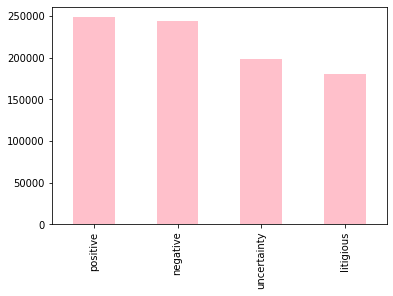

In [ ]:
df['Label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

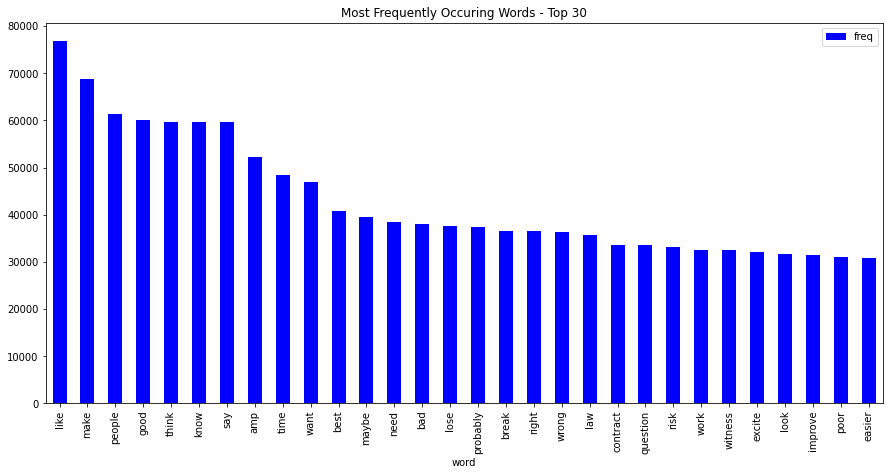

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Clean)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'Vocabulary')

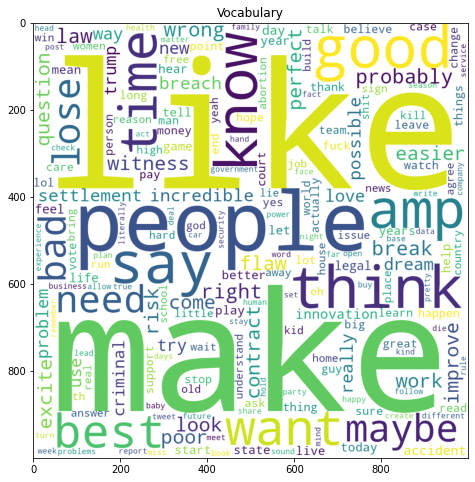

In [ ]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Vocabulary")

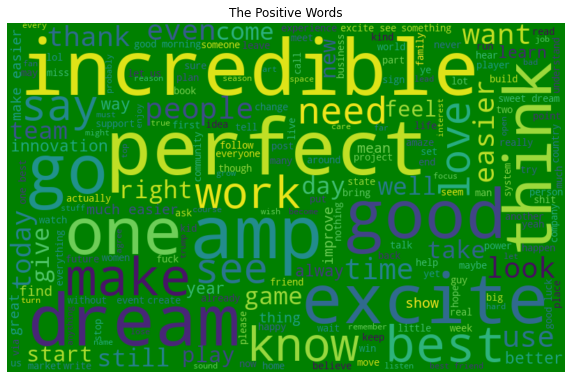

In [ ]:
positive_words =' '.join([text for text in df['Clean'][df['Label'] == "positive"]])

wordcloud = WordCloud(background_color = 'green',width=800, height=500, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

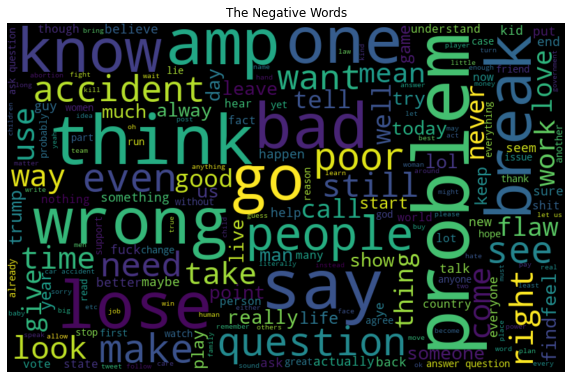

In [ ]:
bad_words =' '.join([text for text in df['Clean'][df['Label'] == "negative"]])

wordcloud = WordCloud(width=800, height=500, max_font_size = 110).generate(bad_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

ML algorithms

In [14]:
df["Label"] = df["Label"].replace("negative", 0)
df["Label"] = df["Label"].replace("litigious", 1)
df["Label"] = df["Label"].replace("positive", 2)
df["Label"] = df["Label"].replace("uncertainty", 3)

In [15]:
# cross validation k-folds 10 folds
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# try different models
models = []
models.append(('LR', LogisticRegression(max_iter=100)))
models.append(('SGD', SGDClassifier()))

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
# store model names and models in a dictionary
model_results = {"LR": [], "SGD": []}
for name, model in models:
    # store the accuracy, precision, recall, f1 score, std and confusion matrix in a dictionary
    results = {"Accuracy": [], "Precision": [], "Recall": [], "F1 Score": [], "Standard Deviation": [], "Confusion Matrix": []}
    for train_index, test_index in kfold.split(df["Clean"], df["Label"]):
        # get the training and testing data
        X_train, X_test = df["Clean"].iloc[train_index], df["Clean"].iloc[test_index]
        y_train, y_test = df["Label"].iloc[train_index], df["Label"].iloc[test_index]
        # fit the vectorizer on the training data
        tfidf.fit(X_train)
        # transform the training and test data
        X_train = tfidf.transform(X_train)
        X_test = tfidf.transform(X_test)
        # fit the model on the training data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        std = np.std(y_pred == y_test) / np.sqrt(y_pred.shape[0])
        cm = confusion_matrix(y_test, y_pred)
        results["Accuracy"].append(accuracy)
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1 Score"].append(f1)
        results["Standard Deviation"].append(std)
        results["Confusion Matrix"].append(cm)
    model_results[name].append(results)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
# print the results
for name, result in model_results.items():
    print(name)
    print("Accuracy: ", np.mean(result[0]["Accuracy"]))
    print("Precision: ", np.mean(result[0]["Precision"]))
    print("Recall: ", np.mean(result[0]["Recall"]))
    print("F1 Score: ", np.mean(result[0]["F1 Score"]))
    print("Standard Deviation: ", np.mean(result[0]["Standard Deviation"]))
    print("Confusion Matrix: ", np.mean(result[0]["Confusion Matrix"], axis=0))
    print()

LR
Accuracy:  0.9663954275745714
Precision:  0.9664438736156301
Recall:  0.9663954275745714
F1 Score:  0.9664124820460241
Standard Deviation:  0.000610488658916227
Confusion Matrix:  [[23519.4   186.8   248.9   459.5]
 [  282.5 17480.9   121.    121.8]
 [  336.9    73.6 24133.6   307.5]
 [  387.1   135.1   267.3 19069.1]]

SGD
Accuracy:  0.9620422123010179
Precision:  0.9622455913551796
Recall:  0.9620422123010179
F1 Score:  0.9620653976088397
Standard Deviation:  0.0006473661876962378
Confusion Matrix:  [[23152.9   222.5   337.4   701.8]
 [  280.2 17426.7   198.4   100.9]
 [  320.2    97.4 23995.1   438.9]
 [  223.3   180.8   205.5 19249. ]]



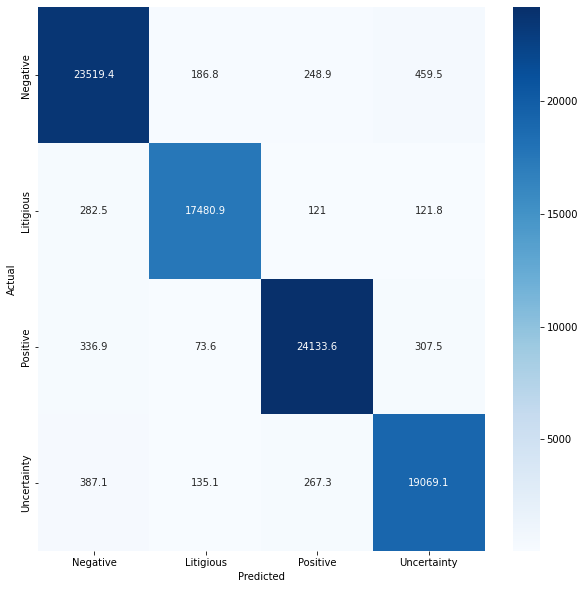

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.mean(model_results["LR"][0]["Confusion Matrix"], axis=0), annot=True,cmap='Blues',fmt='g',
            xticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'], yticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


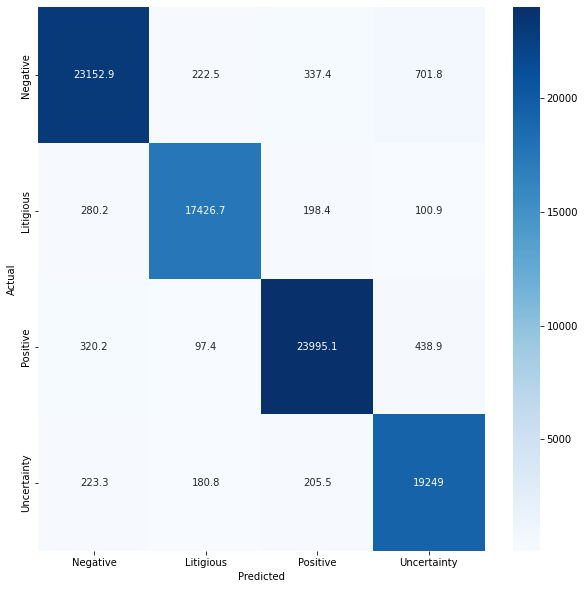

In [ ]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.mean(model_results["SGD"][0]["Confusion Matrix"], axis=0), annot=True,cmap='Blues',fmt='g',
            xticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'], yticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [16]:
def train(model, 
          X_train, y_train, X_test, y_test, 
          checkpoint_path='model.hdf5', 
          epcohs = 10, 
          batch_size = 128, 
          class_weights = None, 
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        validation_data=(X_test, y_test),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 
    # load the best model
    m.load_weights(checkpoint_path)
    # store the accuracy, precision, recall, f1 score, std and confusion matrix in a dictionary
    results = {"Accuracy": [], "Precision": [], "Recall": [], "F1 Score": [], "Standard Deviation": [], "Confusion Matrix": []}
    y_pred = m.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    std = np.std(y_pred == y_test) / np.sqrt(y_pred.shape[0])
    cm = confusion_matrix(y_test, y_pred)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)
    results["Standard Deviation"].append(std)
    results["Confusion Matrix"].append(cm)
    return m ,results

LSTM models

In [37]:
model_results = {"LSTM": [],"LSTM2":[],"LSTM3":[]}

In [39]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim = 212075, output_dim = 128, input_length = 512))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
# train the model with 5-kfold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# store the results in a dictionary

for train_index, test_index in kfold.split(df["Clean"], df["Label"]):
    # get the training and testing data
    X_train, X_test = df["Clean"].iloc[train_index], df["Clean"].iloc[test_index]
    y_train, y_test = df["Label"].iloc[train_index], df["Label"].iloc[test_index]
    # use keras tokenizer to tokenize the text
    tokenizer = Tokenizer(num_words=512)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # pad the sequences
    X_train = pad_sequences(X_train, maxlen=512)
    X_test = pad_sequences(X_test, maxlen=512)
    # convert the labels to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # build the model
    model, results = train(model_1, X_train, y_train, X_test, y_test, epcohs=2, batch_size=128)
    # store the results
    model_results["LSTM"].append((model,results))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 512, 128)          27145600  
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                                 
Total params: 27,285,700
Trainable params: 27,285,700
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2

Epoch 1: val_loss improved from inf to 0.07956, saving model to model.hdf5
5446/5446 - 288s - loss: 0.1030 - accuracy: 0.9589 - val_loss: 0.0796 - val_accura

In [ ]:
def model_2():
    model = Sequential()
    model.add(Embedding(input_dim = 212075, output_dim = 128, input_length = 512))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [46]:
# train the model with 5-kfold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(df["Clean"], df["Label"]):
    # get the training and testing data
    X_train, X_test = df["Clean"].iloc[train_index], df["Clean"].iloc[test_index]
    y_train, y_test = df["Label"].iloc[train_index], df["Label"].iloc[test_index]
    # use keras tokenizer to tokenize the text
    tokenizer = Tokenizer(num_words=512)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # pad the sequences
    X_train = pad_sequences(X_train, maxlen=512)
    X_test = pad_sequences(X_test, maxlen=512)
    # convert the labels to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # build the model
    model, results = train(model_2, X_train, y_train, X_test, y_test, epcohs=2, batch_size=128)
    # store the results
    model_results["LSTM2"].append((model,results))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 512, 128)          27145600  
                                                                 
 lstm_16 (LSTM)              (None, 128)               131584    
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 4)                 132       
                                                                 
Total params: 27,287,652
Trainable params: 27,287,652
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2

Epoch 1: val_loss improve

In [47]:
def model_3():
    model = Sequential()
    model.add(Embedding(input_dim = 212075, output_dim = 64, input_length = 512))
    model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [49]:
# train the model with 5-kfold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(df["Clean"], df["Label"]):
    # get the training and testing data
    X_train, X_test = df["Clean"].iloc[train_index], df["Clean"].iloc[test_index]
    y_train, y_test = df["Label"].iloc[train_index], df["Label"].iloc[test_index]
    # use keras tokenizer to tokenize the text
    tokenizer = Tokenizer(num_words=512)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # pad the sequences
    X_train = pad_sequences(X_train, maxlen=512)
    X_test = pad_sequences(X_test, maxlen=512)
    # convert the labels to categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # build the model
    model, results = train(model_3, X_train, y_train, X_test, y_test, epcohs=2, batch_size=128)
    # store the results
    model_results["LSTM3"].append((model,results))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 512, 64)           13572800  
                                                                 
 lstm_18 (LSTM)              (None, 64)                33024     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 4)                 132       
                                                                 
Total params: 13,608,036
Trainable params: 13,608,036
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2

Epoch 1: val_loss improved from inf to 0.08147, saving model to model.hdf5
5446/5446 - 198s - loss: 0.1152 - accuracy: 0.9548 - val_loss: 0.0815 - val_accura

Visualizing the result

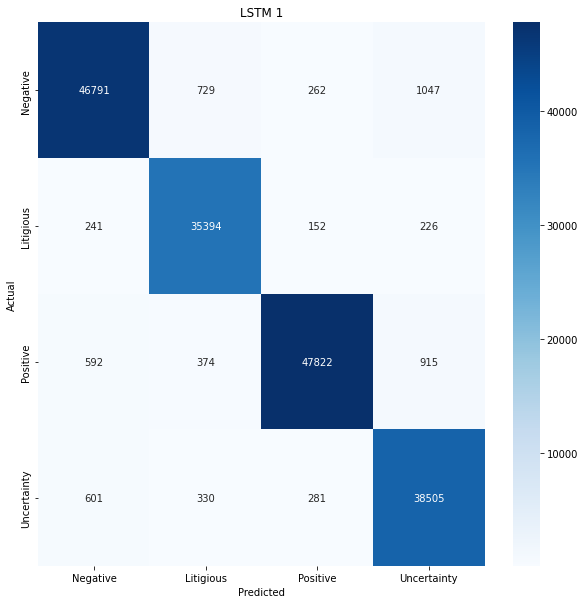

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.mean(model_results["LSTM"][0][1]["Confusion Matrix"], axis=0), annot=True,cmap='Blues',fmt='g',
            xticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'], yticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("LSTM 1")
plt.show()

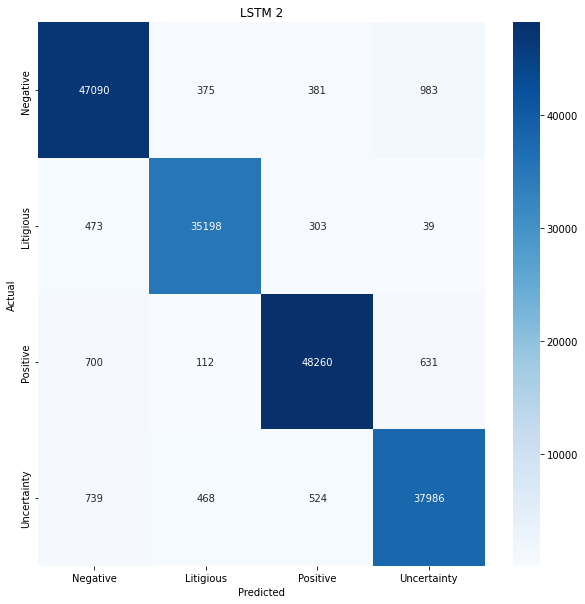

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.mean(model_results["LSTM2"][0][1]["Confusion Matrix"], axis=0), annot=True,cmap='Blues',fmt='g',
            xticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'], yticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("LSTM 2")
plt.show()

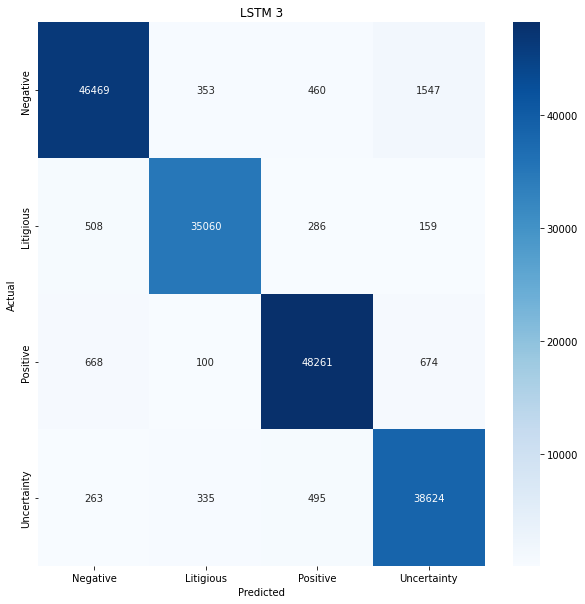

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.mean(model_results["LSTM3"][0][1]["Confusion Matrix"], axis=0), annot=True,cmap='Blues',fmt='g',
            xticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'], yticklabels=['Negative', 'Litigious', 'Positive', 'Uncertainty'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("LSTM 3")
plt.show()

In [64]:
model_results["LSTM"][0][1]

{'Accuracy': [0.9670037070617805],
 'Precision': [0.9672860549194916],
 'Recall': [0.9670037070617805],
 'F1 Score': [0.967036667490929],
 'Standard Deviation': [0.00042790296691111836],
 'Confusion Matrix': [array([[46791,   729,   262,  1047],
         [  241, 35394,   152,   226],
         [  592,   374, 47822,   915],
         [  601,   330,   281, 38505]])]}

In [68]:
model_results["LSTM2"][0][1]

{'Accuracy': [0.9671299537478051],
 'Precision': [0.9671383150758454],
 'Recall': [0.9671299537478051],
 'F1 Score': [0.9671307626260837],
 'Standard Deviation': [0.0004271114633558482],
 'Confusion Matrix': [array([[47090,   375,   381,   983],
         [  473, 35198,   303,    39],
         [  700,   112, 48260,   631],
         [  739,   468,   524, 37986]])]}

In [69]:
model_results["LSTM3"][0][1]

{'Accuracy': [0.9664413354603987],
 'Precision': [0.9666615307329055],
 'Recall': [0.9664413354603987],
 'F1 Score': [0.9664693688244858],
 'Standard Deviation': [0.00043140853829009326],
 'Confusion Matrix': [array([[46469,   353,   460,  1547],
         [  508, 35060,   286,   159],
         [  668,   100, 48261,   674],
         [  263,   335,   495, 38624]])]}